# Recommendation System

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

## 1. Build Utility Matrix from data

Data Source: [GroupLens: MovieLens](https://grouplens.org/datasets/movielens/100k/)

In [2]:
col_names = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_rating = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
                           sep='\t', names=col_names)

In [3]:
col_names = ['movie_id', 'movie title', 'release date', 'video release date', 'IMDb URL', 
             'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', 
                     sep='|', names=col_names, encoding='latin-1')

In [4]:
X = pd.pivot_table(movie_rating, values='rating', index='movie_id', columns='user_id')
X.shape

(1682, 943)

## 2. Truncated SVD:

Replace n/a rating with 0, and then find the first 20 latent variables based on user's rating to represent key feature of each movie.

In [5]:
tSVD = TruncatedSVD(n_components=20, n_iter=10, random_state=33)

In [6]:
t_X = tSVD.fit_transform(X.fillna(0))
t_X.shape

(1682, 20)

In [7]:
corr = pd.DataFrame(np.corrcoef(t_X), index=X.index, columns=X.index)
name_map = {idx: T for idx, T in movies[['movie_id', 'movie title']].values}

def find_similiar_movies(movie_id, n=5):
    
    top_n = corr.loc[corr.index!=movie_id, movie_id].sort_values(ascending=False)[:n]
    top_n_names = pd.Series({idx: name_map[idx] for idx in top_n.index})
    
    print('People who like "%s" also like:'%name_map[movie_id])
    print(top_n_names.tolist())

    return top_n

In [8]:
find_similiar_movies(231)

People who like "Batman Returns (1992)" also like:
['GoldenEye (1995)', 'Batman Forever (1995)', 'Stargate (1994)', 'Batman (1989)', 'Demolition Man (1993)']


movie_id
403    0.973221
62     0.951129
2      0.950907
29     0.948130
578    0.944055
Name: 231, dtype: float64

In [9]:
find_similiar_movies(62)

People who like "Stargate (1994)" also like:
['Star Trek VI: The Undiscovered Country (1991)', 'Batman Returns (1992)', 'Star Trek V: The Final Frontier (1989)', 'Waterworld (1995)', 'Conan the Barbarian (1981)']


movie_id
450    0.958739
231    0.951129
227    0.947768
554    0.946959
679    0.942188
Name: 62, dtype: float64

## 3. Matrix Completion (collaborative filtering)

Idea:

$$X_{filled} \sim L \times U$$

$L, U$ are low rank matrix. $L$ represents latent features for each movie and $U$ represents latent features for each user.

Taking the bias (i.e. average rating per user and per movie) into account, we extend $L$ and $U$ by ones and the bias.

\begin{align}
L_{ext} &= [L; b^{(movie)}; 1] \\
U_{ext}^\top &= [U^\top; 1; b^{(user)}] \\
\end{align}

The estimation for non-rated values is:

$$Y_{i,j} = b^{(movie)}_i + b^{(user)}_j + L_i^\top U_j$$

Regularize by adding the term $\|L\|_F^2+\|U\|_F^2$. To prevent invalid prediction, penalize the prediction for every $Y_{i,j} > 5.5$ or $Y_{i,j} < -0.5 $. Finanally, the cost to minimize is:


$$J = \sum_{(i, j): observed} \left( \left(L_{ext}U_{ext}\right)_{i,j}-X_{i,j} \right)^2 
+ \lambda_1 \left( \|L\|_F^2+\|U\|_F^2 \right) 
+ \lambda_2 \sum_{(i, j): all} \left(\left(Y_{i,j} - 5.5\right)_+ + \left(-0.5 - Y_{i,j}\right)_+\right)$$

In [10]:
def matrix_completion(X, k, lamb, learning_rate=0.03, n_iter=5000):
    
    n_M, n_U = X.shape
    moive_bias = np.nanmean(X, axis=1)
    user_bias = np.nanmean(X, axis=0)
    bias = np.nanmean(X)
    
    mask = np.where(~np.isnan(X).reshape(-1))[0]
    
    tf.reset_default_graph()
    L = tf.Variable(tf.truncated_normal([n_M, k]), name="movies")
    U = tf.Variable(tf.truncated_normal([k, n_U]), name="users")

    L_ext = tf.concat([L, tf.convert_to_tensor(moive_bias.reshape(n_M, 1), dtype=tf.float32), tf.ones((n_M, 1))], 
                      axis=1, name='movie_ext')
    U_ext = tf.concat([U, tf.ones((1, n_U)), tf.convert_to_tensor(user_bias.reshape(1, n_U), dtype=tf.float32)],
                      axis=0, name='user_ext')

    Y = tf.add(tf.matmul(L_ext, U_ext), bias, name='pred')
    
    diff = tf.reshape(tf.subtract(Y, X), [-1], name='diff')
    diff_observed = tf.gather(diff, mask, name='diff_observed')
    
    accuracy = tf.reduce_mean(tf.cast(tf.abs(diff_observed) < 0.5, tf.float32), name='acc')

    sum_sq = tf.reduce_sum(tf.square(diff_observed), name='SS')
    reg = tf.reduce_sum(tf.square(L)) + tf.reduce_sum(tf.square(U))
    extra = tf.reduce_sum(tf.nn.relu(Y - 5.5) + tf.nn.relu(-0.5 - Y), name='extra_penalty')

    cost = sum_sq + lamb[0] * reg + lamb[1] * extra
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    path = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(n_iter):
            
            _, C, C_ss, C_reg, C_ext, acc = sess.run([optimizer, cost, sum_sq, reg, extra, accuracy])
            path.append([C, C_ss, C_reg, C_ext, acc])
            
            if i%500==0: print('iter = %d, J = %.2f, Accuracy = %.2f'%(i, C, acc))
    
        res = sess.run([Y, L, U])
    
    return res, np.array(path)

In [11]:
res, c_path = matrix_completion(X.values, 20, (0.1, 10), n_iter=10000)

iter = 0, J = 83431272.00, Accuracy = 0.02
iter = 500, J = 81637.91, Accuracy = 0.43
iter = 1000, J = 63447.82, Accuracy = 0.49
iter = 1500, J = 51831.09, Accuracy = 0.54
iter = 2000, J = 45363.73, Accuracy = 0.58
iter = 2500, J = 41397.30, Accuracy = 0.60
iter = 3000, J = 38846.28, Accuracy = 0.62
iter = 3500, J = 37117.92, Accuracy = 0.64
iter = 4000, J = 35887.18, Accuracy = 0.65
iter = 4500, J = 35023.89, Accuracy = 0.65
iter = 5000, J = 34427.36, Accuracy = 0.66
iter = 5500, J = 34002.30, Accuracy = 0.66
iter = 6000, J = 33719.66, Accuracy = 0.66
iter = 6500, J = 33486.81, Accuracy = 0.67
iter = 7000, J = 33321.26, Accuracy = 0.67
iter = 7500, J = 33187.39, Accuracy = 0.67
iter = 8000, J = 33071.19, Accuracy = 0.67
iter = 8500, J = 33022.59, Accuracy = 0.67
iter = 9000, J = 32976.66, Accuracy = 0.67
iter = 9500, J = 32988.11, Accuracy = 0.67


Effective rank = 22
Max pred = 5.61
Min Pred = -0.58


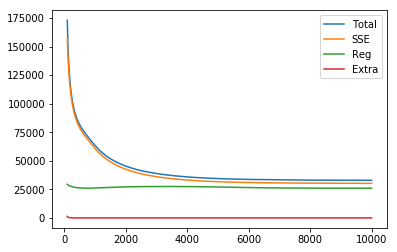

In [12]:
# evaluate result

n_skip = 100
pd.DataFrame(c_path[:, :-1], columns=['Total', 'SSE', 'Reg', 'Extra']).iloc[n_skip:,:].plot()

X_filled = pd.DataFrame(res[0], index=X.index, columns=X.columns)

_, S, _ = np.linalg.svd(X_filled)
print('Effective rank = %d'%(S > 0.01).sum())
print('Max pred = %.2f'%X_filled.values.max())
print('Min Pred = %.2f'%X_filled.values.min())

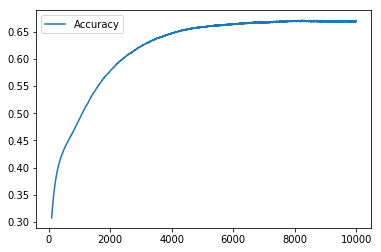

In [13]:
pd.DataFrame(c_path[:, -1], columns=['Accuracy']).iloc[n_skip:,:].plot()

In [14]:
def get_MC_prediction(user_id):

    pred = X_filled.round().loc[pd.isnull(X[user_id]), user_id]
    pred = pd.DataFrame([(name_map[idx], v) for idx, v in pred.iteritems()], columns=['movie title', 'predicted rating'])
    return pred.sort_values('predicted rating', ascending=False)

In [15]:
get_MC_prediction(500)

,movie title,predicted rating
599,Roommates (1995),5.0
707,"Big Lebowski, The (1998)",5.0
268,Fear of a Black Hat (1993),5.0
946,Stalker (1979),5.0
1413,Bitter Sugar (Azucar Amargo) (1996),5.0
1198,My Crazy Life (Mi vida loca) (1993),5.0
130,Nikita (La Femme Nikita) (1990),5.0
1416,Some Mother's Son (1996),5.0
1022,Ghost in the Shell (Kokaku kidotai) (1995),5.0
947,Palookaville (1996),5.0
